# Quickstart

In [1]:
import os

# uncomment to disable NVIDIA GPUs
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
# or pick the device (cpu, gpu, and tpu)
#os.environ['JAX_PLATFORMS'] = 'cpu'

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

# you do not want this
#os.environ['XLA_FLAGS'] = '--xla_gpu_deterministic_ops=true'

import jax
#jax.print_environment_info()

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

NVIDIA H100 PCIe


In [2]:
import matplotlib.pyplot as plt

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann, linear_power, growth,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.pm_util import fftinv
from pmwd.spec_util import powspec
from pmwd.vis_util import simshow

## Simulate Forward

`Configuration` stores static configuration and parameters for which we do not need derivatives.

In [3]:
if jax.default_backend() == 'gpu':
    ptcl_spacing = 1.  # Lagrangian space Cartesian particle grid spacing, in Mpc/h by default
    ptcl_grid_shape = (256,) * 3
else:
    ptcl_spacing = 4.
    ptcl_grid_shape = (64,) * 3

conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=2)  # 2x mesh shape

In [4]:
print(conf)  # with other default parameters
print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')

Configuration(ptcl_spacing=1.0,
              ptcl_grid_shape=(256, 256, 256),
              mesh_shape=(512, 512, 512),
              cosmo_dtype=dtype('float64'),
              pmid_dtype=dtype('int16'),
              float_dtype=dtype('float32'),
              k_pivot_Mpc=0.05,
              T_cmb=2.7255,
              M=1.98847e+40,
              L=3.0856775815e+22,
              T=3.0856775815e+17,
              transfer_fit=True,
              transfer_fit_nowiggle=False,
              transfer_lgk_min=-4,
              transfer_lgk_max=3,
              transfer_lgk_maxstep=0.0078125,
              growth_rtol=1.4901161193847656e-08,
              growth_atol=1.4901161193847656e-08,
              growth_inistep=(1, None),
              lpt_order=2,
              a_start=0.015625,
              a_stop=1,
              a_lpt_maxstep=0.0078125,
              a_nbody_maxstep=0.015625,
              symp_splits=((0, 0.5), (1, 0.5)),
              chunk_size=16777216)
Simulating 167772

`Cosmology` stores interesting parameters, whose derivatives we need.

In [5]:
cosmo = Cosmology(conf, A_s_1e9=2.0, n_s=0.96, Omega_m=0.3, Omega_b=0.05, h=0.7)
# or simply use the predefined SimpleLCDM
#cosmo = SimpleLCDM(conf)

print(cosmo)

Cosmology(A_s_1e9=Array(2., dtype=float64),
          n_s=Array(0.96, dtype=float64),
          Omega_m=Array(0.3, dtype=float64),
          Omega_b=Array(0.05, dtype=float64),
          h=Array(0.7, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          transfer=None,
          growth=None,
          varlin=None)


``boltzmann`` computes the transfer and growth functions and caches them in ``Cosmology``.

The first run is slower because it includes the **JIT compilation** time. JAX uses **asynchronous dispatch** to hide Python overheads. To measure the true cost, use ``jax.block_until_ready()`` to wait for the computation to complete.

In [6]:
%time cosmo = jax.block_until_ready(boltzmann(cosmo, conf))
%timeit jax.block_until_ready(boltzmann(cosmo, conf))

CPU times: user 2.14 s, sys: 212 ms, total: 2.35 s
Wall time: 2 s
14.2 ms ± 21.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Generate a white noise field, and scale it with the linear power spectrum:

In [7]:
seed = 0
modes = white_noise(seed, conf)

modes = linear_modes(modes, cosmo, conf)

Solve LPT at some early time:

In [8]:
%time ptcl, obsvbl = jax.block_until_ready(lpt(modes, cosmo, conf))
%timeit jax.block_until_ready(lpt(modes, cosmo, conf))
ptcl.disp.std(), ptcl.vel.std()

CPU times: user 1.37 s, sys: 41.1 ms, total: 1.42 s
Wall time: 821 ms
8.93 ms ± 4.89 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


(Array(0.105, dtype=float32), Array(0.007, dtype=float32))

Finally, N-body time integration from the LPT initial conditions:

In [9]:
%time jax.block_until_ready(nbody(ptcl, obsvbl, cosmo, conf))
%time ptcl, obsvbl = jax.block_until_ready(nbody(ptcl, obsvbl, cosmo, conf))
ptcl.disp.std(), ptcl.vel.std()

CPU times: user 3.31 s, sys: 618 ms, total: 3.93 s
Wall time: 3.56 s
CPU times: user 689 ms, sys: 543 ms, total: 1.23 s
Wall time: 1.4 s


(Array(5.318, dtype=float32), Array(3.286, dtype=float32))

Scatter the particles to mesh to get the density field, and plot a slab's 2D projection:

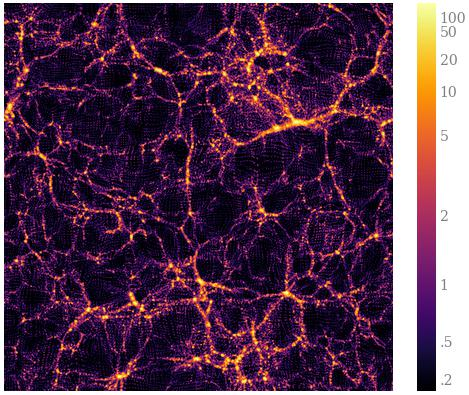

In [10]:
dens = scatter(ptcl, conf)
simshow(dens[:16].mean(axis=0), norm='CosmicWebNorm');

Measure and plot the matter density power spectra:

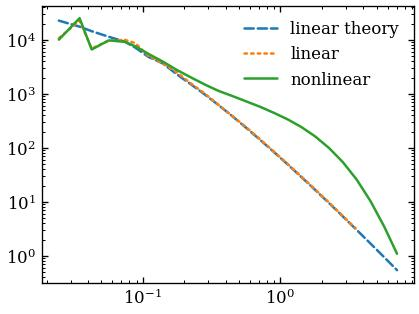

In [11]:
k, P, _, _ = powspec(dens, conf.cell_size)

dens_lin = fftinv(modes, shape=conf.ptcl_grid_shape, norm=conf.ptcl_spacing)
dens_lin *= growth(conf.a_stop, cosmo, conf)
k_lin, P_lin, _, _ = powspec(dens_lin, conf.ptcl_spacing)

P_linth = linear_power(k, conf.a_stop, cosmo, conf)

plt.figure(figsize=(4, 3), dpi=120)
plt.loglog(k, P_linth, ls='--', label='linear theory')
plt.loglog(k_lin, P_lin, ls=':', label='linear')
plt.loglog(k, P, ls='-', label='nonlinear')
plt.legend();

We can combine all steps together:

In [12]:
cosmo = SimpleLCDM(conf)
modes = white_noise(seed, conf)

def model(modes, cosmo, conf):
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    return ptcl, obsvbl

print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')
%time jax.block_until_ready(model(modes, cosmo, conf));

Simulating 16777216 particles with a (512, 512, 512) mesh for 63 time steps.
CPU times: user 711 ms, sys: 545 ms, total: 1.26 s
Wall time: 1.43 s


## Simulate Forward and Differentiate Backward

For the gradient, we use the same ``Configuration`` and ``Cosmology`` as before, but different white noise ``modes``.

In [13]:
seed = 1  # change the seed for a different realization, to be compared to the previous one in the objective
modes = white_noise(seed, conf, real=True)  # this time we want real modes to look at their gradients

Define a simple MSE objective function between this and the previous realizations of density fields, and differentiate it with respect to the modes and cosmological parameters:

In [14]:
def obj(tgt_dens, modes, cosmo, conf):
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    dens = scatter(ptcl, conf)
    return (dens - tgt_dens).var()

obj_grad = jax.grad(obj, argnums=(1, 2))

print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps, '
      'and then differentiating backward.')
%time jax.block_until_ready(obj_grad(dens, modes, cosmo, conf))
%time modes_grad, cosmo_grad = jax.block_until_ready(obj_grad(dens, modes, cosmo, conf))

Simulating 16777216 particles with a (512, 512, 512) mesh for 63 time steps, and then differentiating backward.
CPU times: user 20.4 s, sys: 2.32 s, total: 22.7 s
Wall time: 19.3 s
CPU times: user 3.39 s, sys: 1.9 s, total: 5.29 s
Wall time: 5.27 s


A slice of the mode gradients:

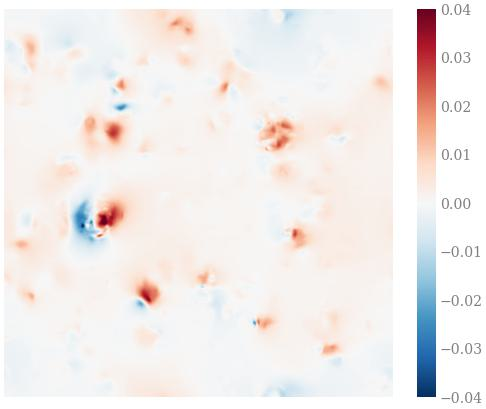

In [15]:
simshow(modes_grad[..., 0], cmap='RdBu_r', vmin=-0.04, vmax=0.04);

Cosmological parameter gradients:

In [16]:
print(cosmo_grad)

Cosmology(A_s_1e9=Array(51.601, dtype=float64),
          n_s=Array(121.798, dtype=float64),
          Omega_m=Array(569.083, dtype=float64),
          Omega_b=Array(-1422.57, dtype=float64),
          h=Array(361.472, dtype=float64),
          Omega_k_=None,
          w_0_=None,
          w_a_=None,
          transfer=None,
          growth=None,
          varlin=None)
